In [179]:
# !pip install ucimlrepo
# !pip install imblearn
# !pip install "ray[tune]"
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_curve,auc, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


%matplotlib inline 

In [180]:
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
df = breast_cancer_wisconsin_diagnostic.data.features 
labels = breast_cancer_wisconsin_diagnostic.data.targets 

In [181]:
def data_preparation(df, labels):
    X = df.copy()
    y = labels.copy()
    X['mean_radius'] = (X['radius1'] + X['radius2'] + X['radius3']) / 3
    X['mean_area'] = (X['area1'] + X['area2'] + X['area3']) / 3
    X['mean_perimeter'] = (X['perimeter1'] + X['perimeter2'] + X['perimeter3']) / 3
    
    high_corr_columns = ['radius1', 'radius2', 'radius3', 'perimeter1', 'perimeter2', 'perimeter3', 'area1', 'area2', 'area3']
    X.drop(columns=high_corr_columns, inplace=True)
    
    numerical_columns = ['texture1', 'smoothness1', 'compactness1', 'concavity1',
       'concave_points1', 'symmetry1', 'fractal_dimension1', 'texture2',
       'smoothness2', 'compactness2', 'concavity2', 'concave_points2',
       'symmetry2', 'fractal_dimension2', 'texture3', 'smoothness3',
       'compactness3', 'concavity3', 'concave_points3', 'symmetry3',
       'fractal_dimension3', 'mean_radius', 'mean_area', 'mean_perimeter']
    
    for col in numerical_columns:
        X[col] = np.cbrt(X[col])
        
        IQR = X[col].quantile(0.75) - X[col].quantile(0.25)

        # Compute bounds
        lower_bound = X[col].quantile(0.25) - 1.5 * IQR
        upper_bound = X[col].quantile(0.75) + 1.5 * IQR

        # Set values outside the bounds to NaN
        X[col] = np.where(
            (X[col] <= lower_bound) | (X[col] >= upper_bound),
            np.nan,
            X[col]
        )
        
        X['target'] = np.where(y == 'M', 1, 0)
        X.dropna(inplace=True)
        X.reset_index(drop=True)
        y = X['target']
        X.drop(columns=['target'], inplace=True)
        X = X.to_numpy()
        return X, y

In [182]:
X, y = data_preparation(df, labels)

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [184]:
smote = SMOTE()
smote.fit(X_train, y_train)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [185]:
def model_applier(data, model_name):
    
    if model_name == 'LogisticRegression':
        X_train, y_train, X_test, y_test = data
        X_train = np.column_stack((np.ones(X_train.shape[0]), X_train))
        X_test = np.column_stack((np.ones(X_test.shape[0]), X_test))
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
        
        return (lr, results)
    
    if model_name == 'NaiveBayes':
        X_train, y_train, X_test, y_test = data
        gnb = GaussianNB()
        gnb.fit(X_train, y_train)
        y_pred = gnb.predict(X_test)

        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (gnb, results)
    
    if model_name == 'KNN':
        X_train, y_train, X_test, y_test = data
        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X_train, y_train)
        y_pred = neigh.predict(X_test)
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (neigh, results)
    
    if model_name == 'SVM':
        X_train, y_train, X_test, y_test = data
        clf = svm.SVC()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (clf, results) 

    if model_name == 'DecisionTreeClassifier':
        X_train, y_train, X_test, y_test = data
        clf = DecisionTreeClassifier(random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (clf, results)

    if model_name == 'RandomForestClassifier':
        X_train, y_train, X_test, y_test = data
        clf = RandomForestClassifier(max_depth=16, random_state=0)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (clf, results)
    
    if model_name == 'BaseLineClassifier':
        X_train, y_train, X_test, y_test = data
        y_pred = np.random.choice([0, 1], size=y_test.shape)
        results = {
            'confusion_matrix':confusion_matrix(y_test, y_pred),
            'accuracy_score':accuracy_score(y_test, y_pred),
            'recall_score':recall_score(y_test, y_pred),
            'precision_score':precision_score(y_test, y_pred),
            'f1_score':f1_score(y_test, y_pred)
        }
    
        return (None, results)

In [186]:
models = ['LogisticRegression', 'NaiveBayes', 'KNN', 'SVM', 'DecisionTreeClassifier', 'RandomForestClassifier', 'BaseLineClassifier']
data = (X_train_smote, y_train_smote, X_test, y_test)
results = {}
for model in models:
    results[model] = model_applier(data, model)    

/opt/anaconda3/envs/car-price-prediction-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [187]:
rows = []
for model_name, (model, metrics) in results.items():
    row = {'Model': model_name}
    row.update(metrics)  # Add all metric values
    rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)

df


,Model,confusion_matrix,accuracy_score,recall_score,precision_score,f1_score
0,LogisticRegression,"[[66, 2], [1, 45]]",0.973684,0.978261,0.957447,0.967742
1,NaiveBayes,"[[66, 2], [3, 43]]",0.956140,0.934783,0.955556,0.945055
2,KNN,"[[62, 6], [2, 44]]",0.929825,0.956522,0.880000,0.916667
3,SVM,"[[66, 2], [5, 41]]",0.938596,0.891304,0.953488,0.921348
4,DecisionTreeClassifier,"[[61, 7], [2, 44]]",0.921053,0.956522,0.862745,0.907216
5,RandomForestClassifier,"[[65, 3], [1, 45]]",0.964912,0.978261,0.937500,0.957447
6,BaseLineClassifier,"[[33, 35], [25, 21]]",0.473684,0.456522,0.375000,0.411765


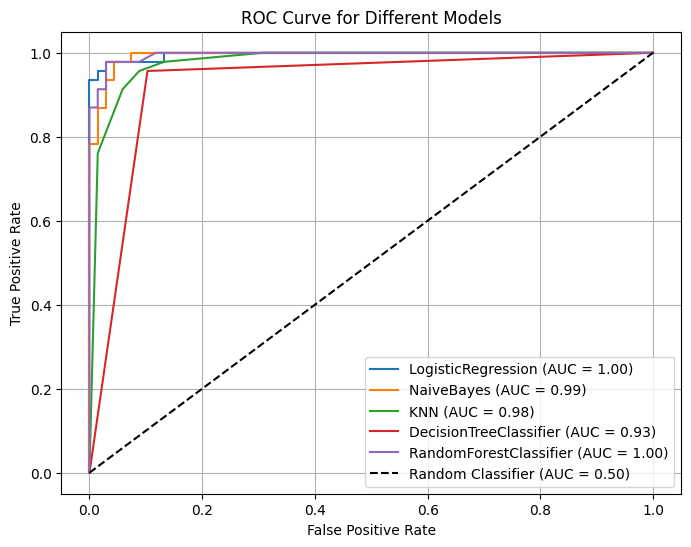

In [188]:
# Initialize the plot
plt.figure(figsize=(8, 6))

for model_name, (model, _) in results.items():
    
    if model_name == 'LogisticRegression':
        # Ensure the intercept term is included
        y_probs = model.predict_proba(np.column_stack((np.ones(X_test.shape[0]), X_test)))[:, 1]
    
    elif model_name in ['SVM', 'BaseLineClassifier']:
        # Skip these models
        continue
    
    else:    
        # Get predicted probabilities for other models
        y_probs = model.predict_proba(X_test)[:, 1]
    
    # Compute ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')

# Add labels, title, and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(loc='lower right')
plt.grid(True)

# Show the plot
plt.show()


## Optimizing parameters on Logistic Regression

In [189]:
X_ = np.concatenate((X_train, X_test), axis=0)
y_ = np.concatenate((y_train, y_test), axis=0)

In [190]:
smote = SMOTE()
smote.fit(X_, y_)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_smote = np.column_stack((np.ones(X_train_smote.shape[0]), X_train_smote))

In [191]:
search = GridSearchCV(LogisticRegression(), {'C': [0.01, 0.1, 1, 10, 100]}, cv=5)
search.fit(X_train_smote, y_train_smote)

/opt/anaconda3/envs/car-price-prediction-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


/opt/anaconda3/envs/car-price-prediction-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/envs/car-price-prediction-env/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100]})

In [192]:
X_val = np.column_stack((np.ones(X_val.shape[0]), X_val))
y_pred = search.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96        74
           1       0.88      0.97      0.93        39

    accuracy                           0.95       113
   macro avg       0.93      0.95      0.94       113
weighted avg       0.95      0.95      0.95       113

